# Final Project Machine Learning

*By Basri Satiroglu, Daniel Deutsch and José Lucas Barretto.*

In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from statsmodels.tools.tools import pinv_extended
from keras.callbacks import History 

In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Problematic

Two-sided platforms are multi-sided platforms that connect two distinct but interdependent client groups. By connecting these groups, they add value as mediators. There are several examples of two sided platforms such as Netflix, Facebook, YouTube, etc. that, in a very simplified point of view, connect product consumers and product providers.

On every two-sided network we can analyse what we call network side effects. These are the consequences of the increment or decrease of providers or clients in the network.


Online shopping websites such as Amazon, Walmart, Mercado Livre, Rakouten, etc. are also considered two sided platforms. What they do is basically connect product buyers and sellers through their ready and easy-to-use UI/UX.

The side effects generated between sellers and sellers ends up generating some sort of competition between people/companies that sell the same product on the platform. And they have to 
This way, it is in our interest to analyse what characterists matter the most in 

# Dataset

## About the Data

The dataset used in our analysis has the following structure:

| Index &nbsp; | Name               | Description                                 |
|--------------|:-------------------|--------------------------------------------:|
|  0           | `prod_asin`        | Amazon's identifier of the product          |
|  1           | `prod_condition`   | Condition of the product (new, used, ...)   |
|  2           | `prod_price`       | Price of the product (in USD)               |
|  3           | `seller_index`     | Position of the seller offer in the buy box |
|  4           | `seller_name`      | Name of the seller                          |
|  5           | `seller_rating`    | Rating of the seller $ \in [0, 5]$          |
|  6           | `seller_n_reviews` | Number of reviews that the seller has       |

It contains information about the buy box of each one of the products of the two first pages of results when searching for the following queries on the Amazon platform:

- Macbook Pro
- Dell Xps
- Webcam
- Playstation
- Joystick
- Gaming Headset
- Body Weight Scale
- Omega 3
- Body Lotion
- Carpet
- Lamp
- Silverware
- Telescope
- Weather Station
- Arduino
- Sunglasses
- T-shirt
- Purse
- Baseball Bat
- Basketball
- Punching Bag

It is important to say that this data was collected in June of 2021, so for sure the dataset isn't updated, but the results we may get from it still hold for the sample. Its also important to say that the data was collected as if someone was using the website from New York and without cookies in its computer (Amazon's results changes based on this informations about the user as they are known for using price steering in their platform).

In [3]:
# Loads the dataframe
df = pd.read_csv("./datasets/amzn.csv", index_col=0)

# Numericalize columns
df = df.apply(pd.to_numeric, errors='ignore')

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN
...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN


## Data Processing

### Output Metric

It is of course problematic to the model if we just use the seller index as our y variable since there are products that only have one offer and products with more than 20. Therefore, it is necessery for us to create a metric able to represent "how close the offer is to being the first on the buy box". We decided, then, to implement the following metric:

$
    y = 1 - \frac{\text{seller index}}{\text{number of sellers of the product}}
$

Notice that this metric somehow "inverts" the notion of the seller index, i.e. the closer the metric is to 1, the higher is the position of the seller in the buy box.

In [4]:
# Gets the number of sellers of each product
df['y'] = df.groupby('prod_asin')['seller_index'].transform('max') + 1

# Calculates y
df['y'] = 1 - df['seller_index'] / df['y']

df 

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333
...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667


### One Hot Encoding

The algorithms we are going to use need to be able to interpret the dataset. Because of that it is advantageous to perform one hot encoding in the column `prod_condition`.

In [5]:
# Performs one hot encoding in the prod_condition column
df = pd.concat([df, pd.get_dummies(df['prod_condition'])], axis=1)

# Renames the new columns
df.rename(columns={ 'Collectible': 'is_collectible', 'New': 'is_new', 'Open': 'is_open', 'Renewed': 'is_renewed', 'To': 'is_to', 'Used': 'is_used' }, inplace=True)

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667,0,1,0,0,0,0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333,1,0,0,0,0,0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000,0,1,0,0,0,0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000,0,1,0,0,0,0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000,0,1,0,0,0,0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667,0,0,0,0,0,1


In our analysis we also intend to see if Amazon is gives itself advantages so, to facilitate its interpretation it is also interesting to add a column saying whether amazon is the seller of the product or not. This was done simply by selecting the `seller_name` that cointains the word amazon (case insensitive) in it (1 means that Amazon is the seller).

In [6]:
# Performs one hot encoding in the seller n
df['is_amazon'] = df['seller_name'].str.contains('amazon', case=False).replace({True: 1, False: 0})

df

,prod_asin,prod_condition,prod_price,seller_index,seller_name,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used,is_amazon
0,B01D8KOZF4,New,36.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0,1.0
1,B01D8KOZF4,New,73.00,1.0,OUT-OF-THIS-WORLD-TREASURES-WORLDWIDE SHIPPING,92.0,193.0,0.666667,0,1,0,0,0,0,0.0
2,B01D8KOZF4,Collectible,78.00,2.0,More,92.0,193.0,0.333333,1,0,0,0,0,0,0.0
3,B01EWNUUUA,New,59.00,0.0,Amazon.com,96.0,13630.0,1.000000,0,1,0,0,0,0,1.0
4,B01EWNUUUA,Used,55.00,1.0,Amazon Warehouse,NaN,NaN,0.833333,0,0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7363,B092QQKXJ4,New,21.00,0.0,Amazon.com,100.0,10.0,1.000000,0,1,0,0,0,0,1.0
7364,B092QQKXJ4,New,21.00,1.0,Harlanppme,100.0,2.0,0.500000,0,1,0,0,0,0,0.0
7365,B088LLXMXY,New,27.00,0.0,Amazon.com,91.0,325.0,1.000000,0,1,0,0,0,0,1.0
7366,B088LLXMXY,Used,9.16,1.0,More,NaN,NaN,0.666667,0,0,0,0,0,1,0.0


## Interesting Stats

### Simple Data Description

In [7]:
df.describe()

,prod_price,seller_index,seller_rating,seller_n_reviews,y,is_collectible,is_new,is_open,is_renewed,is_to,is_used,is_amazon
count,7283.000000,7368.000000,5659.000000,5.659000e+03,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7368.000000,7245.000000
mean,129.590428,3.049674,88.915179,2.744411e+04,0.628732,0.001900,0.761536,0.008008,0.027552,0.003393,0.197204,0.346722
std,277.788603,2.966256,12.038345,9.889240e+04,0.300293,0.043552,0.426173,0.089132,0.163695,0.058155,0.397915,0.475959
min,1.710000,0.000000,0.000000,1.000000e+00,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,84.000000,1.650000e+02,0.363636,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,2.000000,92.000000,1.479000e+03,0.636364,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,99.000000,5.000000,97.000000,8.695000e+03,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3399.000000,10.000000,100.000000,1.086661e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Histogram Product Conditions

Here we can see that most of the product offers in the dataset are from new products.

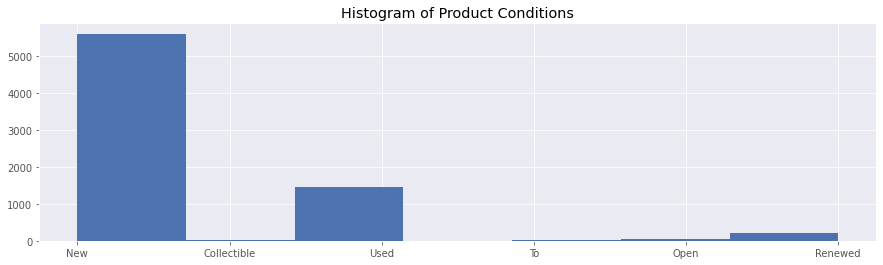

In [8]:
# Obtains the number of bins for the histogram
nbins = len(df['prod_condition'].unique())

# Plots the histogram
df['prod_condition'].hist(bins=nbins)
plt.title("Histogram of Product Conditions")
plt.show()

### Histogram of Sellers

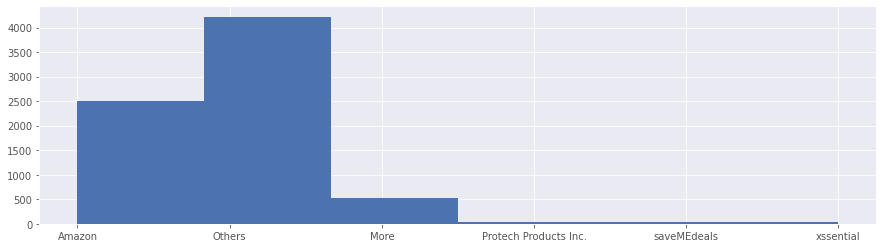

In [9]:
# Considers all Amazon 
df['seller_name_top_n'] = ['Amazon' if 'amazon' in str(seller_name).lower() else seller_name for seller_name in df['seller_name']]

# Obtains top n sellers names
n = 5
top_sellers = df['seller_name_top_n'].value_counts()[:n].index.tolist()

# Builds column with top n sellers and names the remaining as others
df['seller_name_top_n'] = [seller_name if seller_name in top_sellers else 'Others' for seller_name in df['seller_name_top_n']]

# Plots the histogram
df['seller_name_top_n'].hist(bins=n+1)
plt.show()

# Models

Now, our goal is to 

In [10]:
# Drops not available infos
df.dropna(inplace=True)

# List of features
features = ['prod_price', 'seller_rating', 'seller_n_reviews', 'is_collectible', 'is_new', 'is_open', 'is_renewed', 'is_to', 'is_used', 'is_amazon']

# Separates the df into input (X) and output (y) matrices
X = df[features]
y = df['y']

# Separates the data in train and test sets (test should be 20% of total)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"Size of the training set: {X_train.shape[0]}")
print(f"Size of the test set: {X_test.shape[0]}")

# Center and standarize the train and test covariates
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Creates a results dataframes for comparison
df_results = pd.DataFrame()

Size of the training set: 4466
Size of the test set: 1117


### Auxiliary Functions

Since we are using

In [11]:
def R2(y_true, y_pred):
    """Returns the determination coefficient (R^2) given the labels predictions and true values.

    Args:
        y_true (nparray): true value of labels.
        y_pred (nparray): predicted values of labels.

    Returns:
        float: Determination Coefficient
    """
    RSS = ((y_true-y_pred)**2).sum()          # Residual Sum of Squares 
    TSS = ((y_true-y_true.mean())**2).sum()   # Total Sum of Squares
    r2 = 1 - RSS/TSS                          # Determination Coefficient
    return r2


def MSE(y_true, y_pred):
    """Returns the mean squared error (MSE) given the labels predictions and true values.

    Args:
        y_true (nparray): true value of labels.
        y_pred (nparray): predicted values of labels.

    Returns:
        float: mean squared error (MSE)
    """
    mse = ((y_pred-y_true)**2).mean(axis=0)
    return mse


def seller_indexes_correlation(df, y_pred):
    """Returns the correlation between the predicted seller indexes and the adjusted ones.

    Args:
        df (pd.DataFrame): DataFrame with the whole dataset
        y_pred (pd.Series): Series with the predicted y

    Returns:
        [float]: Correlation between predicteed indexes and adjusted ones.
    """
    # Only considers the rows that are in y_pred
    df_tmp = pd.merge(df, y_pred.rename('y_pred'), left_index=True, right_index=True)
    
    # Since some of the rows were dropped, there are some products whose lowest seller index offer isn't 0, so we adjust that
    df_tmp['adj_seller_index'] = df_tmp.sort_values('seller_index', ascending=True).groupby('prod_asin').cumcount()
    
    # We reverse our previously made metric to obtain the seller index
    df_tmp['pred_seller_index'] = df_tmp.sort_values('y_pred', ascending=False).groupby('prod_asin').cumcount()

    # Returns the correlation between the adjusted and the prediction
    return df_tmp['adj_seller_index'].corr(df_tmp['pred_seller_index'])


### Benchmark model: OLS

In this section we simply do an OLS regression using our previously made metric as the independent variable to understand which features are significant for the selction of the buy box.

In [12]:
# Creates a model with the training data
model = sm.OLS(y_train, X_train)   # Creates the model
model_fit = model.fit()            # Fits the model

print(model_fit.summary(xname=features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     662.7
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:23:03   Log-Likelihood:                 424.41
No. Observations:                4466   AIC:                            -832.8
Df Residuals:                    4458   BIC:                            -781.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price        3.109e-06   1.35e-05  

In [13]:
# Predicts y_test using the model_fit and X_test as input
y_pred = model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['OLS'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using OLS we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using OLS we have: R^2=0.50785, MSE=0.04855 and correlation: 0.62449


### Challenger Model I: Ridge

In [14]:
# Cross validates the alpha based on the AIC
best_model_fit, best_aic, best_alpha = None, None, None
for alpha in np.logspace(-3, 1, 100):

    # Creates a model with the training data
    model = sm.OLS(y_train, X_train)                          # Creates the model
    model_fit = model.fit_regularized(alpha=alpha, L1_wt=0)   # Fits the model

    # Obtains the normalized cov params for building the summary
    pinv_wexog, _ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

    # Obtains the results
    r = sm.regression.linear_model.OLSResults(model, model_fit.params, normalized_cov_params)

    # Makes sure that it works on the first iteration
    if not best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

    # Updates the best model based on the AIC
    if r.aic < best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

# Obtains the normalized cov params for building the summary of the best model
pinv_wexog, _ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

# Obtains the results of the best model
r = sm.regression.linear_model.OLSResults(model, best_model_fit.params, normalized_cov_params)

print(f"The chosen alpha was {best_alpha}")
print(r.summary())

The chosen alpha was 0.001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     659.3
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:23:05   Log-Likelihood:                 418.62
No. Observations:                4466   AIC:                            -821.2
Df Residuals:                    4458   BIC:                            -770.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price   

c:\Users\Dell\Desktop\Code\FTD\Scoring and ML\project\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [15]:
# Predicts y_test using the model_fit and X_test as input
y_pred = best_model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Ridge'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using Ridge we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using Ridge we have: R^2=0.50523, MSE=0.04881 and correlation: 0.63519


### Challenger Model II: Lasso

In [16]:
# Cross validates the alpha based on the AIC
best_model_fit, best_aic, best_alpha = None, None, None
for alpha in np.logspace(-3, 1, 100):

    # Creates a model with the training data
    model = sm.OLS(y_train, X_train)                          # Creates the model
    model_fit = model.fit_regularized(alpha=alpha, L1_wt=1)   # Fits the model

    # Obtains the normalized cov params for building the summary
    pinv_wexog, _ = pinv_extended(model.wexog)
    normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

    # Obtains the results
    r = sm.regression.linear_model.OLSResults(model, model_fit.params, normalized_cov_params)

    # Makes sure that it works on the first iteration
    if not best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

    # Updates the best model based on the AIC
    if r.aic < best_aic:
        best_model_fit = model_fit
        best_aic = r.aic
        best_alpha = alpha

# Obtains the normalized cov params for building the summary of the best model
pinv_wexog, _ = pinv_extended(model.wexog)
normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))

# Obtains the results of the best model
r = sm.regression.linear_model.OLSResults(model, best_model_fit.params, normalized_cov_params)

print(f"The chosen alpha was {best_alpha}")
print(r.summary())

The chosen alpha was 0.001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     626.9
Date:                Thu, 20 Jan 2022   Prob (F-statistic):               0.00
Time:                        21:23:12   Log-Likelihood:                 362.00
No. Observations:                4466   AIC:                            -708.0
Df Residuals:                    4458   BIC:                            -656.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
prod_price   

c:\Users\Dell\Desktop\Code\FTD\Scoring and ML\project\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


In [17]:
# Predicts y_test using the model_fit and X_test as input
y_pred = best_model_fit.predict(X_test)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['Lasso'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using Lasso we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using Lasso we have: R^2=0.48788, MSE=0.05052 and correlation: 0.57742


### Challenger Model III: Neural Network

Now, we implement a simple neural network with to check the same results.


In [42]:
# Instantiates the network
model = keras.Sequential()

# Builds the model network structure
model.add(layers.Dense(100, input_dim=len(features)))
model.add(layers.ReLU())
model.add(layers.Dense(200))
model.add(layers.ReLU())
model.add(layers.Dense(200))
model.add(layers.ReLU())
model.add(layers.Dense(100))
model.add(layers.Dense(1, activation='sigmoid'))

# Compiles the network
adam = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.99)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])

# Trains the network
history = History()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), validation_freq=1, batch_size=10, verbose=1)


Epoch 1/100
447/447 [==============================] - 2s 2ms/step - loss: 0.2919 - accuracy: 0.2297 - val_loss: 0.2546 - val_accuracy: 0.2739
Epoch 2/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.2913 - val_loss: 0.2545 - val_accuracy: 0.2739
Epoch 3/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2384 - accuracy: 0.2985 - val_loss: 0.2545 - val_accuracy: 0.2739
Epoch 4/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2384 - accuracy: 0.2980 - val_loss: 0.2545 - val_accuracy: 0.2739
Epoch 5/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.2956 - val_loss: 0.2546 - val_accuracy: 0.2739
Epoch 6/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2399 - accuracy: 0.2895 - val_loss: 0.2567 - val_accuracy: 0.2507
Epoch 7/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2419 - accuracy: 0.2929 - val_loss: 0.2546 - val_accuracy: 0.2739

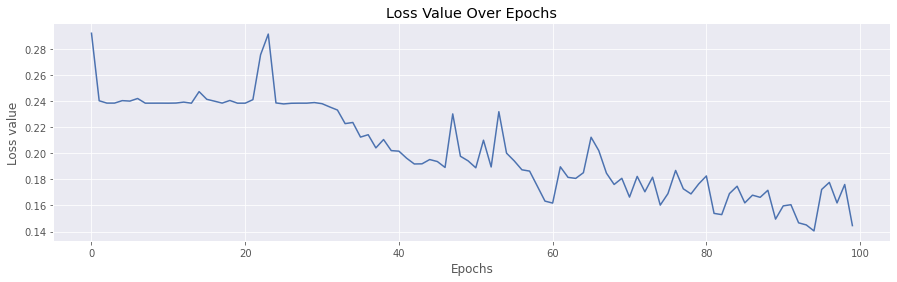

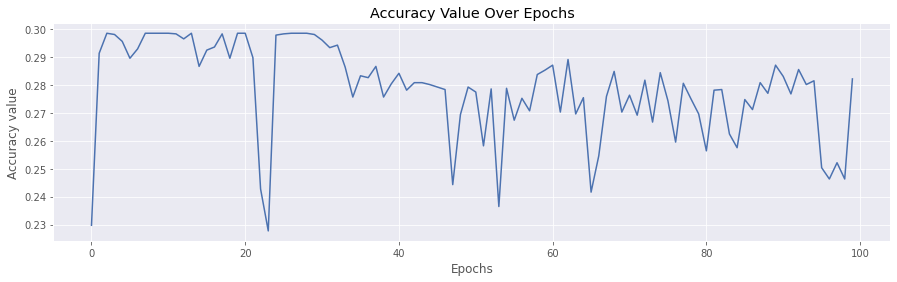

In [44]:
# Plots the loss (MSE) over epochs
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])
plt.title("Loss Value Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

# Plots the accuracy over epochs
plt.plot(np.arange(len(history.history["accuracy"])), history.history["accuracy"])
plt.title("Accuracy Value Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy value")
plt.show()

In [49]:
# Predicts y_test using the model_fit and X_test as input
y_pred = model.predict(X_test).flatten()
y_pred = pd.Series(y_pred, y_test.index)

# Obtains the R^2 and the mse of the test data
r2 = R2(y_test, y_pred)
mse = MSE(y_test, y_pred)
corr = seller_indexes_correlation(df, y_pred)

# Adds the results to df_results
df_results = df_results.append(pd.DataFrame({'method': ['NN'], 'R2': [r2], 'MSE': [mse], 'correlation': corr}), ignore_index=True)

print(f"For the test data using NN we have: R^2={r2:.5f}, MSE={mse:.5f} and correlation: {corr:.5f}")

For the test data using NN we have: R^2=-0.66354, MSE=0.16412 and correlation: 0.55389


# Result Analysis

In [ ]:
# Plot the number of zero coefficients in each method
ax = df_results.agg(lambda row: row.eq(0).sum()).sort_values().plot(
    kind="barh",
    figsize=(15, 4),
    title="Number of Zero Coefficients in Each Method",
)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(),
                                         p.get_y()), xytext=(5, 10), textcoords='offset points')

In [50]:
df_results

,method,R2,MSE,correlation
0,OLS,0.507849,0.048554,0.624494
1,Ridge,0.505235,0.048812,0.635192
2,Lasso,0.487879,0.050524,0.577422
3,NN,-0.663535,0.164120,0.553886


## Data Science Point of View

## Business Point of View